In [636]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [486]:
cars_df = pd.read_csv('cars_dataset.csv')
cars_df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi


In [488]:
n, m = cars_df.shape
print(f'Количество автомобилей (объектов) = {n}, количество признаков = {m}')

Количество автомобилей (объектов) = 72435, количество признаков = 10


Теперь посмотрим **полную информацию** о датафрейме

In [491]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72435 entries, 0 to 72434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         72435 non-null  object 
 1   year          72435 non-null  int64  
 2   price         72435 non-null  int64  
 3   transmission  72435 non-null  object 
 4   mileage       72435 non-null  int64  
 5   fuelType      72435 non-null  object 
 6   tax           72435 non-null  float64
 7   mpg           72435 non-null  float64
 8   engineSize    72435 non-null  float64
 9   Make          72435 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 5.5+ MB


Посмотрим количество **уникальных** моделей и количество **уникальных** производителей

In [494]:
unique_models = cars_df['model'].nunique()
unique_maker = cars_df['Make'].nunique()
print(f'Количество уникальных моделей - {unique_models}, количество уникальных производителей - {unique_maker}')

Количество уникальных моделей - 146, количество уникальных производителей - 7


Посмотрим какие модели (то есть модель + марка) **самые популярные** (топ-5)

In [497]:
most_popular = cars_df.groupby(['model', 'Make']).agg({'year' : 'count'}).sort_values('year', ascending=False)
most_popular.reset_index(inplace=True)
most_popular['Car'] = most_popular['Make'] + ' ' +  most_popular['model']
most_popular.rename(columns={'year' : 'count_cars'}, inplace=True)
most_popular = most_popular[[col for col in most_popular.columns if col == 'Car' or col == 'count_cars']]
most_popular.head()

,count_cars,Car
0,6556,Ford Fiesta
1,4863,vw Golf
2,4588,Ford Focus
3,3287,vw Polo
4,2443,BMW 3 Series


Самая популярная модель оказалась Ford Fiesta... но да ладно

Теперь можно посмотреть на различные графики, например на **графики распределения** по продажам автомобилей

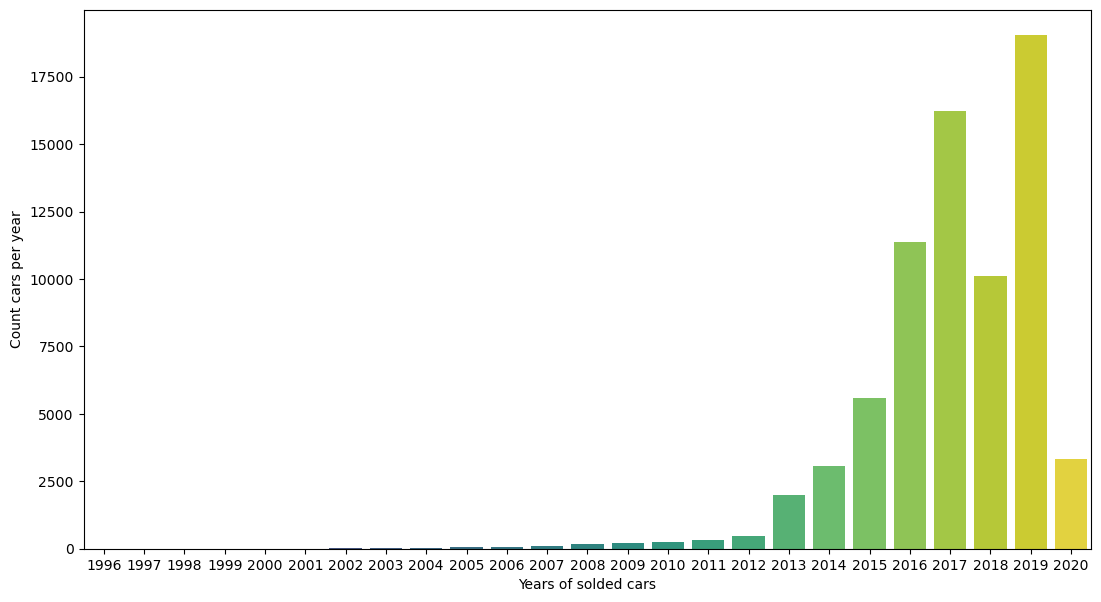

In [501]:
years_cdf = cars_df.groupby('year').agg({'price' : 'count'})
years_cdf.reset_index(inplace=True)
years_cdf.rename(columns={'price' : 'count_cars'}, inplace=True)

plt.figure(figsize=(13, 7));
sns.barplot(x=years_cdf['year'], y=years_cdf['count_cars'], data=years_cdf, palette='viridis', hue=years_cdf['year'], legend=False);
years_numeric = years_cdf['year'].astype(int)
plt.xlabel('Years of solded cars');
plt.ylabel('Count cars per year');

Вывод можно сделать несколько выводов: либо в 2013 году произошел **резкий скачок** продаж автомобилей, либо данные в датафрейме активно **собирались** после 2013 года 

Сгруппируем **по годам** и посмотрим тенденцию продаж автомобилей

In [504]:
cars_df.groupby('year').agg({'model' : 'count'})

,model
year,
1996,2
1997,2
1998,4
1999,5
2000,6
2001,8
2002,17
2003,22
2004,32


До 2007-го года продавалось **меньше 100 машин** в год... Очень странный вывод по **представленным данным**, но будем придерживаться **гипотезы**, что данные в датафрейме **были утеряны** до 2007-го года. 

Далее будем рассматривать датафрейм, **не включая** продажи до 2007-го

In [507]:
cars_df_new = cars_df.query('year >= 2007')
cars_df_new.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi


Если перейдем в поле, где мы смотрели **информацию о датасете**, то заметим, что он весит всего **5.5 МБ**, при этом есть много типов данных `int64` и `object`. Предположим, что у нас датасет может весить в **1000 раз больше**, но оперативная память - **конечное** число, значит необходимо **"урезать" датасет** так, чтобы он занимал меньше памяти

In [515]:
cars_df_copy = cars_df_new.copy()
int_float_cols = [col for col in cars_df_new.columns if cars_df_new[col].dtype == int or cars_df_new[col].dtype == float]
object_cols = [col for col in cars_df_new.columns if cars_df_new[col].dtype == 'object']
for col in int_float_cols:
    cars_df_copy[col] = pd.to_numeric(cars_df_new[col], downcast='unsigned')
for col in ['transmission', 'fuelType']:
    cars_df_copy[col] = cars_df_new[col].astype(bool) # с точки зрения нормальных людей есть только бензин и дизель, но 
                                                      # в кодировании признаков гибриды и электрички тоже учтем
cars_df_copy.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 72218 entries, 0 to 72434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         72218 non-null  object 
 1   year          72218 non-null  uint16 
 2   price         72218 non-null  uint32 
 3   transmission  72218 non-null  bool   
 4   mileage       72218 non-null  uint32 
 5   fuelType      72218 non-null  bool   
 6   tax           72218 non-null  uint16 
 7   mpg           72218 non-null  float64
 8   engineSize    72218 non-null  float64
 9   Make          72218 non-null  object 
dtypes: bool(2), float64(2), object(2), uint16(2), uint32(2)
memory usage: 3.7+ MB


В начале создали **копию** начального датафрейма, а то Pandas ругается :)

Теперь каждый признак имеет **приемлемый** тип данных. Поясню, что сделано: если колонка - численный признак, то тип данных уменьшается, если есть такая возможность. Если рассматривать категориальную колонку: дату преобразуем из `object` в `pd.datetime`, а типы данных с небольшим количеством уникальных значений (в нашем случае 2) переводим либо в `boolean` (True/False), либо в `int` (1/0)

Из начальных **5.5 МБ** мы перешли в **3.7 МБ**. При условии, что признаков (как и объектов) может быть намного больше - отличный результат

Перейдем к графикам. Визуализируем распределение по моделям. Выведем **15 самых популярных моделей** и количество их продаж. Какой самый популярный автомобиль - вывод был сделан выше

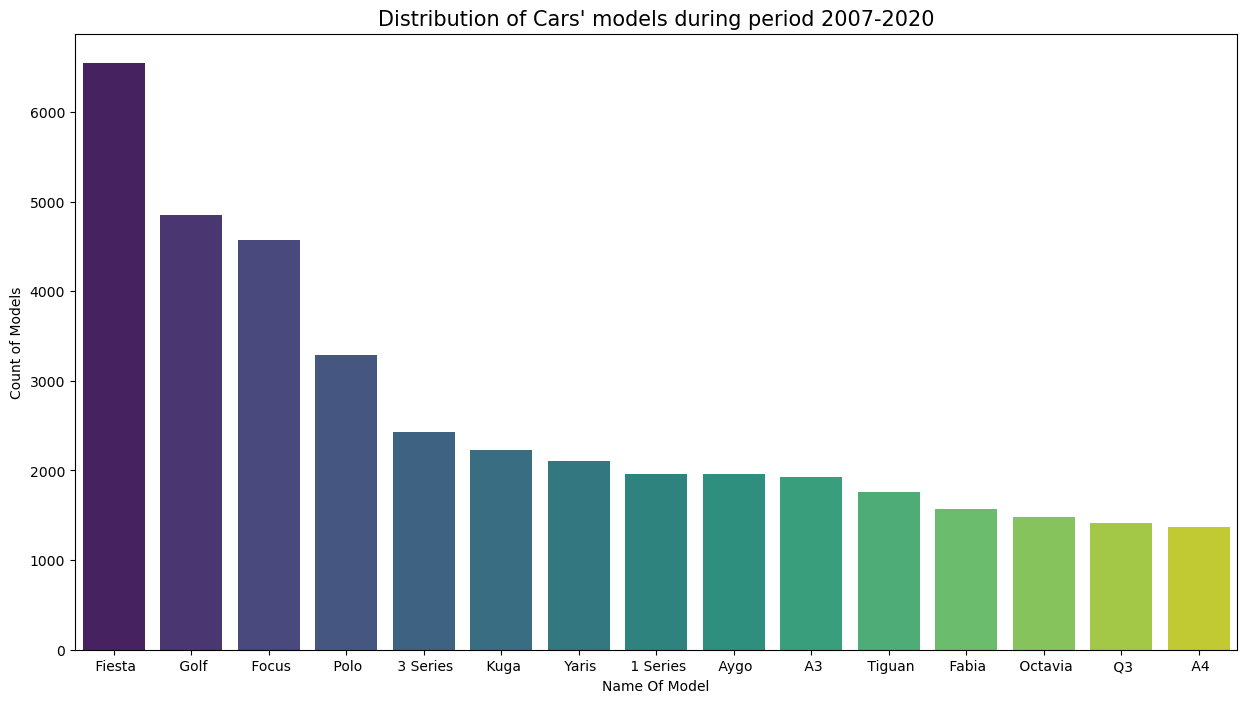

In [518]:
count_models = cars_df_copy['model'].value_counts().reset_index().head(15)
plt.figure(figsize=(15, 8));
sns.barplot(data=count_models, x=count_models['model'], y=count_models['count'], palette='viridis', hue='model', legend=False);
plt.xlabel('Name Of Model');
plt.ylabel('Count of Models');
plt.title("Distribution of Cars' models during period 2007-2020", size=15);

Самый прикол год от года это наблюдать за тем, как **меняется цена** на каждую модель `(особенно в момент выхода рестайлинга)`

Чтобы это визуализировать, построим лайнплот цены от года на **КАЖДУЮ** из **15 самых продаваемых моделей** (и немного погрустим об Октавии ниже 5000$)

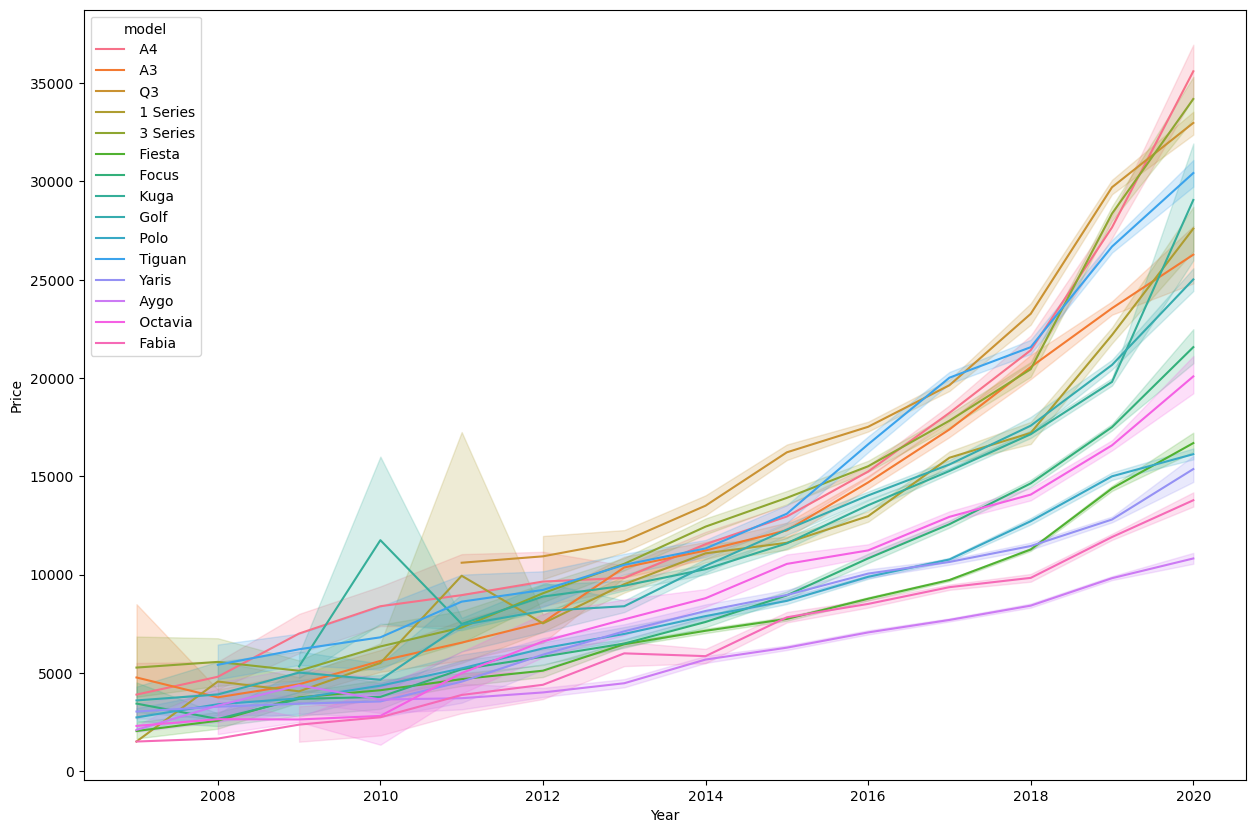

In [521]:
fifteen_models = cars_df_copy[cars_df_copy['model'].isin(count_models['model'])]
plt.figure(figsize=(15, 10));
sns.lineplot(data=fifteen_models, x='year', y='price', hue='model');
plt.xlabel('Year');
plt.ylabel('Price');

Думаю, выводы делать не стоит, все итак **видно** на графике.

Теперь визуализируем распределение **пробега, цены и налога**. Это нам нужно для дальнейших действий

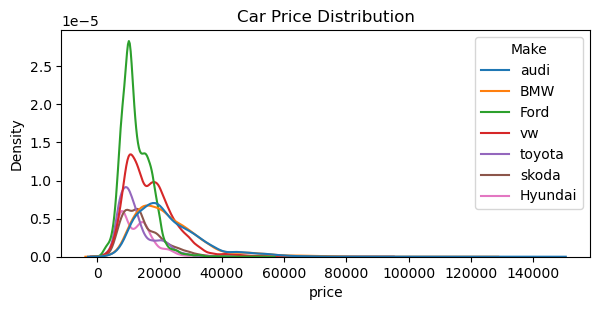

In [524]:
plt.figure(figsize=(15,10));
plt.subplot(3,2,1);
sns.kdeplot(data=cars_df_copy, x="price", hue="Make");
plt.title("Car Price Distribution");

Видим, что на графиках присутствуют **выбросы**. Для проведения **дальнейшего анализа** (в частности и для применения машинного обучения), например, для **тестирования различных гипотез**, их надо убрать!

Так же решил не чистить выбросы в признаке `Объем двигателя`, так как он довольно **сильно коррелирует** с итоговой ценой

In [555]:
left = 0.01
right = 0.99

cars_copy_new = cars_df_new.copy()
print(f'Первоначальный размер датафрейма: {len(cars_copy_new)}')
for col in int_float_cols:
    if col != 'price' and col != 'engineSize':
        left_bound, right_bound = cars_copy_new[col].quantile([left, right])
        cars_copy_new = cars_copy_new[(cars_copy_new[col] >= left_bound - 1) & (cars_copy_new[col] <= right_bound - 1)]
        print(f'Размер датафрейма после очистки признака {col} от выбросов: {len(cars_copy_new)}')

Первоначальный размер датафрейма: 72218
Размер датафрейма после очистки признака year от выбросов: 68631
Размер датафрейма после очистки признака mileage от выбросов: 67275
Размер датафрейма после очистки признака tax от выбросов: 66446
Размер датафрейма после очистки признака mpg от выбросов: 65170


Но сначала посмотрим на то, как вещественные признаки **коррелируют** между друг другом. Для машинного обучения будет интересовать корреляция между **ценой** и **каждым другим признаком**

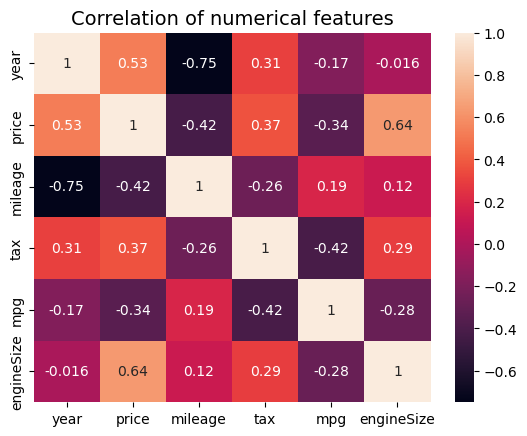

In [460]:
sns.heatmap(cars_df_copy[int_float_cols].corr(), annot=True);
plt.title('Correlation of numerical features', size=14);

Между ценой и всеми остальными вещественными признаками наблюдается довольно **высокая корреляция**. Да, некоторые признаки **довольно сильно** коррелируют между друг другом, но их **убирать не будем**.

Так как в датасете **нет пропусков** и этот момент нет необходимости обрабатывать, идем к **кодировке данных**. Для этого посчитаем по каждой колонке типа `object` количество уникальных значений, в зависимости от их количества будем применять кодировку

In [557]:
cat_cols = [col for col in cars_copy_new.columns if cars_copy_new[col].dtype == 'object']
for col in cat_cols:
    unique_values = cars_copy_new[col].nunique()
    print(f'У признака {col} - {unique_values} уникальных значений')

У признака model - 126 уникальных значений
У признака transmission - 4 уникальных значений
У признака fuelType - 5 уникальных значений
У признака Make - 7 уникальных значений


Только **одна** колонка имеет очень много уникальных значений. Но 140 не соизмеримо с 72 000, поэтому этот признак будем кодировать с помощью `Mean Target Encoding`. В остальных случаях - `One Hot Encoding`

In [574]:
ml_cars = cars_copy_new.copy()
for col in cat_cols:
    if col != 'model':
        dummies = pd.get_dummies(ml_cars[col], drop_first=True, dtype='int')
        ml_cars = pd.concat([ml_cars.drop(columns=[col]), dummies], axis=1)
    else:
        model_mean_prices = ml_cars.groupby(col)['price'].mean()
        ml_cars[col] = ml_cars[col].map(model_mean_prices)
print('Размер нового датасета:', ml_cars.shape)
ml_cars.head()

Размер нового датасета: (65170, 20)


,model,year,price,mileage,tax,mpg,engineSize,Manual,Other,Semi-Auto,Electric,Hybrid,Other,Petrol,Ford,Hyundai,audi,skoda,toyota,vw
0,13701.788462,2017,12500,15735,150.0,55.4,1.4,1,0,0,0,0,0,1,0,0,1,0,0,0
1,22814.371758,2016,16500,36203,20.0,64.2,2.0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,13701.788462,2016,11000,29946,30.0,55.4,1.4,1,0,0,0,0,0,1,0,0,1,0,0,0
3,19603.502028,2017,16800,25952,145.0,67.3,2.0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,17581.179944,2019,17300,1998,145.0,49.6,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0


Количество исходных признаков увеличилось в 2 раза. Теперь можем разделить данные на **матрицу признаков X** и **вектор ответов Y** и попробовать решить с помощью **линейной регрессии**

Обучим модель с помощью встроенной библиотеки `Sklearn` и с помощью **аналитического решения**

In [683]:
X = np.array(ml_cars[[col for col in ml_cars.columns if col != 'price' and col != 'Other']])
Y = np.array(ml_cars['price'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

Есть такая штука - **стандартизация** данных. Но попробуем без нее)

In [686]:
def analys_regress(x_t, y_t):
    XTX = x_t.T @ x_t
    XTX_minus_one = np.linalg.pinv(XTX)
    XTY = x_t.T @ y_t
    W = XTX_minus_one @ XTY
    return W

In [688]:
X_train_ones = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_ones = np.c_[np.ones((X_test.shape[0], 1)), X_test]

W_t = analys_regress(X_train_ones, Y_train)
Y_pred = X_test_ones @ W_t
Y_pred_train = X_train_ones @ W_t
print(f'Среднее по тестовым = {Y_test.mean()}, среднее по тренировочным = {Y_train.mean()}')
print()
print(f'MAE for test = {mean_absolute_error(Y_pred, Y_test)}')
print(f'MSE for test = {mean_squared_error(Y_pred, Y_test)}')
print(f'RMSE for test = {np.sqrt(mean_squared_error(Y_pred, Y_test))}')
print()
print(f'MAE for train = {mean_absolute_error(Y_pred_train, Y_train)}')
print(f'MSE for train = {mean_squared_error(Y_pred_train, Y_train)}')
print(f'RMSE for train = {np.sqrt(mean_squared_error(Y_pred_train, Y_train))}')

Среднее по тестовым = 15809.2477622628, среднее по тренировочным = 15772.821083320547

MAE for test = 2190.839068201996
MSE for test = 9120391.758023283
RMSE for test = 3019.99863543401

MAE for train = 2208.71657074281
MSE for train = 9519136.895174697
RMSE for train = 3085.309853997601


Значение не на **стандартизированных данных** неплохие. Попробуем их стандартизировать, то есть приведем к **нормальному распределению** каждый признак. В этом обучении **стандартизировать вектор ответов** не буду

In [711]:
scaler_train = StandardScaler()
scaler_test = StandardScaler()

scaler_train.fit(X_train)
scaler_test.fit(X_test)

X_train_scaled = scaler_train.transform(X_train)
X_test_scaled = scaler_test.transform(X_test)

X_train_ones = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_ones = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

W_t = analys_regress(X_train_ones, Y_train)
Y_pred = X_test_ones @ W_t
Y_pred_train = X_train_ones @ W_t
print(f'Среднее по тестовым = {Y_test.mean()}, среднее по тренировочным = {Y_train.mean()}')
print()
print(f'MAE for test = {mean_absolute_error(Y_pred, Y_test)}')
print(f'MSE for test = {mean_squared_error(Y_pred, Y_test)}')
print(f'RMSE for test = {np.sqrt(mean_squared_error(Y_pred, Y_test))}')
print()
print(f'MAE for train = {mean_absolute_error(Y_pred_train, Y_train)}')
print(f'MSE for train = {mean_squared_error(Y_pred_train, Y_train)}')
print(f'RMSE for train = {np.sqrt(mean_squared_error(Y_pred_train, Y_train))}')

Среднее по тестовым = 15809.2477622628, среднее по тренировочным = 15772.821083320547

MAE for test = 1892.4014413148857
MSE for test = 7039742.467148036
RMSE for test = 2653.2513011676892

MAE for train = 1902.1608546017414
MSE for train = 7404417.638357365
RMSE for train = 2721.105958678817


Что ж, значения метрик стали на **10-20% ниже**, чем до стандартизации. Попробуем использовать **встроенную библиотеку** для обучения, сразу будем брать стандартизированные данные

In [714]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, Y_train)

LinearRegression()

In [716]:
test_pred = lin_model.predict(X_test_scaled)
train_pred = lin_model.predict(X_train_scaled)
print(f'Среднее по тестовым = {Y_test.mean()}, среднее по тренировочным = {Y_train.mean()}')
print()
print(f'MAE for test = {mean_absolute_error(test_pred, Y_test)}')
print(f'MSE for test = {mean_squared_error(test_pred, Y_test)}')
print(f'RMSE for test = {np.sqrt(mean_squared_error(test_pred, Y_test))}')
print()
print(f'MAE for train = {mean_absolute_error(train_pred, Y_train)}')
print(f'MSE for train = {mean_squared_error(train_pred, Y_train)}')
print(f'RMSE for train = {np.sqrt(mean_squared_error(train_pred, Y_train))}')

Среднее по тестовым = 15809.2477622628, среднее по тренировочным = 15772.821083320547

MAE for test = 1892.4014413149075
MSE for test = 7039742.467148039
RMSE for test = 2653.2513011676897

MAE for train = 1902.1608546017626
MSE for train = 7404417.638357365
RMSE for train = 2721.105958678817


Результаты **аналогичны** аналитическому решению. Что ж, модель работает достаточно **неплохо**

В этом мини-проекте были выполнены **следующие шаги:**
1) Проведен **EDA-анализ**, построены **графики**
2) Датафрейм был обработан специально для **машинного обучения**
3) Была обучена модель с помощью **аналитического метода** линейной регрессии и с использованием **встроенной библиотеки** `sklearn`
4) Были посчитаны **метрики** качества модели - `MAE`, `MSE`, `RMSE`